In [ ]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('fixed.csv')

us_data = df[df['State'] == 'United States'].copy()

data = us_data[['Age Group', 'Condition Group', 'COVID-19 Deaths']].copy()

le_age = LabelEncoder()
le_condition = LabelEncoder()

data.loc[:, 'Age_encoded'] = le_age.fit_transform(data['Age Group'])
data.loc[:, 'Condition_encoded'] = le_condition.fit_transform(data['Condition Group'])

median_deaths = data['COVID-19 Deaths'].median()
data.loc[:, 'High_Deaths'] = (data['COVID-19 Deaths'] > median_deaths).astype(int)

print("="*80)
print("FULL PREPARED DATAFRAME")
print("="*80)
print(data)
print("\nDataframe shape:", data.shape)

X = data[['Age_encoded', 'COVID-19 Deaths']].copy()
y_multinomial = data['Condition_encoded'].copy()  # For multinomial NB
y_bernoulli = data['High_Deaths'].copy()  # For Bernoulli NB
y_gaussian = data['COVID-19 Deaths'].copy()  # For Gaussian NB (continuous target)

X_train, X_test, y_train_multi, y_test_multi = train_test_split(
    X, y_multinomial, test_size=0.3, random_state=42)
_, _, y_train_bern, y_test_bern = train_test_split(
    X, y_bernoulli, test_size=0.3, random_state=42)
_, _, y_train_gauss, y_test_gauss = train_test_split(
    X, y_gaussian, test_size=0.3, random_state=42)

train_multi = pd.concat([X_train, y_train_multi], axis=1)
test_multi = pd.concat([X_test, y_test_multi], axis=1)

train_bern = pd.concat([X_train, y_train_bern], axis=1)
test_bern = pd.concat([X_test, y_test_bern], axis=1)

train_gauss = pd.concat([X_train, y_train_gauss], axis=1)
test_gauss = pd.concat([X_test, y_test_gauss], axis=1)

print("\n" + "="*80)
print("MULTINOMIAL NAIVE BAYES DATA")
print("="*80)
print("\nFull Training Set:")
print(train_multi)
print("\nTraining Set shape:", train_multi.shape)
print("\nFull Testing Set:")
print(test_multi)
print("\nTesting Set shape:", test_multi.shape)

print("\n" + "="*80)
print("BERNOULLI NAIVE BAYES DATA")
print("="*80)
print("\nFull Training Set:")
print(train_bern)
print("\nTraining Set shape:", train_bern.shape)
print("\nFull Testing Set:")
print(test_bern)
print("\nTesting Set shape:", test_bern.shape)

print("\n" + "="*80)
print("GAUSSIAN NAIVE BAYES DATA")
print("="*80)
print("\nFull Training Set:")
print(train_gauss)
print("\nTraining Set shape:", train_gauss.shape)
print("\nFull Testing Set:")
print(test_gauss)
print("\nTesting Set shape:", test_gauss.shape)

FULL PREPARED DATAFRAME
      Age Group       Condition Group  COVID-19 Deaths  Age_encoded  \
0          0-24  Respiratory diseases           1569.0            0   
1         25-34  Respiratory diseases           5804.0            1   
2         35-44  Respiratory diseases          15080.0            2   
3         45-54  Respiratory diseases          37414.0            3   
4         55-64  Respiratory diseases          82668.0            4   
...         ...                   ...              ...          ...   
72445  All Ages              COVID-19            321.0            8   
72446  All Ages              COVID-19            379.0            8   
72447  All Ages              COVID-19            405.0            8   
72448  All Ages              COVID-19            345.0            8   
72449  All Ages              COVID-19            312.0            8   

       Condition_encoded  High_Deaths  
0                      9            1  
1                      9            1  
2  

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np

df = pd.read_csv('fixed.csv')
us_data = df[df['State'] == 'United States'].copy()

data = us_data[['Age Group', 'Condition Group', 'Condition', 'COVID-19 Deaths', 'Number of Mentions']].copy()

data['Death_Rate'] = data['COVID-19 Deaths'] / (data['Number of Mentions'].replace(0, 1))

le_age = LabelEncoder()
le_condition = LabelEncoder()
le_condition_group = LabelEncoder()

data['Age_encoded'] = le_age.fit_transform(data['Age Group'])
data['Condition_encoded'] = le_condition.fit_transform(data['Condition'])
data['Condition_Group_encoded'] = le_condition_group.fit_transform(data['Condition Group'])

threshold = data['COVID-19 Deaths'].quantile(0.75)
data['High_Deaths'] = (data['COVID-19 Deaths'] > threshold).astype(int)

X = data[['Age_encoded', 'Condition_Group_encoded', 'Death_Rate']]
y_multi = data['Condition_Group_encoded']
y_bern = data['High_Deaths']
y_gauss = data['COVID-19 Deaths']

X_train, X_test, y_train_multi, y_test_multi, y_train_bern, y_test_bern, y_train_gauss, y_test_gauss = \
    train_test_split(X, y_multi, y_bern, y_gauss, test_size=0.3, random_state=42)

sample_weights_multi = compute_sample_weight('balanced', y_train_multi)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =====================================================================
# IMPROVED MULTINOMIAL NAIVE BAYES
# =====================================================================
print("\n" + "="*80)
print("IMPROVED MULTINOMIAL NAIVE BAYES")
print("="*80)
mnb = MultinomialNB()
mnb.fit(X_train, y_train_multi, sample_weight=sample_weights_multi)
y_pred_multi = mnb.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test_multi, y_pred_multi, 
                          target_names=le_condition_group.classes_,
                          zero_division=0))
print("Accuracy:", accuracy_score(y_test_multi, y_pred_multi))

# =====================================================================
# IMPROVED BERNOULLI NAIVE BAYES
# =====================================================================
print("\n" + "="*80)
print("IMPROVED BERNOULLI NAIVE BAYES")
print("="*80)
bnb = BernoulliNB()
bnb.fit(X_train, y_train_bern)
y_pred_bern = bnb.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test_bern, y_pred_bern,
                          target_names=['Low Deaths', 'High Deaths'],
                          zero_division=0))
print("Accuracy:", accuracy_score(y_test_bern, y_pred_bern))

# =====================================================================
# IMPROVED GAUSSIAN NAIVE BAYES
# =====================================================================
print("\n" + "="*80)
print("IMPROVED GAUSSIAN NAIVE BAYES")
print("="*80)
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train_gauss)
y_pred_gauss = gnb.predict(X_test_scaled)

print("\nRegression Metrics:")
print("Mean Squared Error:", mean_squared_error(y_test_gauss, y_pred_gauss))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test_gauss, y_pred_gauss)))
print("Mean Absolute Error:", np.mean(np.abs(y_test_gauss - y_pred_gauss)))

# Feature importance using variance (correct attribute name)
if hasattr(gnb, 'var_'):
    print("\nFeature Importance (Variance):")
    for i, feature in enumerate(['Age Group', 'Condition Group', 'Death Rate']):
        print(f"{feature}: {gnb.var_[:, i].mean():.2f}")

# Show some predictions vs actuals
results_sample = pd.DataFrame({
    'Age Group': le_age.inverse_transform(X_test['Age_encoded']),
    'Condition Group': le_condition_group.inverse_transform(y_test_multi),
    'Predicted Condition Group': le_condition_group.inverse_transform(y_pred_multi),
    'Actual Deaths': y_test_gauss,
    'Predicted Deaths': y_pred_gauss,
    'High Deaths Actual': y_test_bern,
    'High Deaths Predicted': y_pred_bern
})

print("\nSample Predictions (First 10 rows):")
print(results_sample.head(10))


IMPROVED MULTINOMIAL NAIVE BAYES

Classification Report:
                                                                           precision    recall  f1-score   support

                               All other conditions and causes (residual)       1.00      1.00      1.00       140
                                                        Alzheimer disease       0.70      0.74      0.72       151
                                                                 COVID-19       0.08      0.27      0.13       157
                                                     Circulatory diseases       0.64      0.18      0.29      1048
                                                                 Diabetes       0.14      0.23      0.18       149
Intentional and unintentional injury, poisoning, and other adverse events       0.09      0.15      0.11       143
                                                      Malignant neoplasms       0.05      0.12      0.07       152
                     

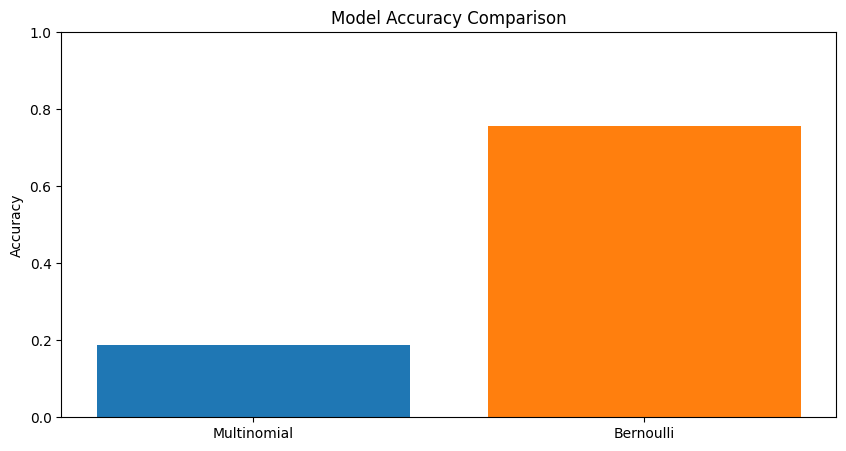

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Accuracy comparison
models = ['Multinomial', 'Bernoulli', 'Gaussian']
accuracies = [0.188, 0.757, None]
plt.figure(figsize=(10,5))
plt.bar(models[:2], accuracies[:2], color=['#1f77b4', '#ff7f0e'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

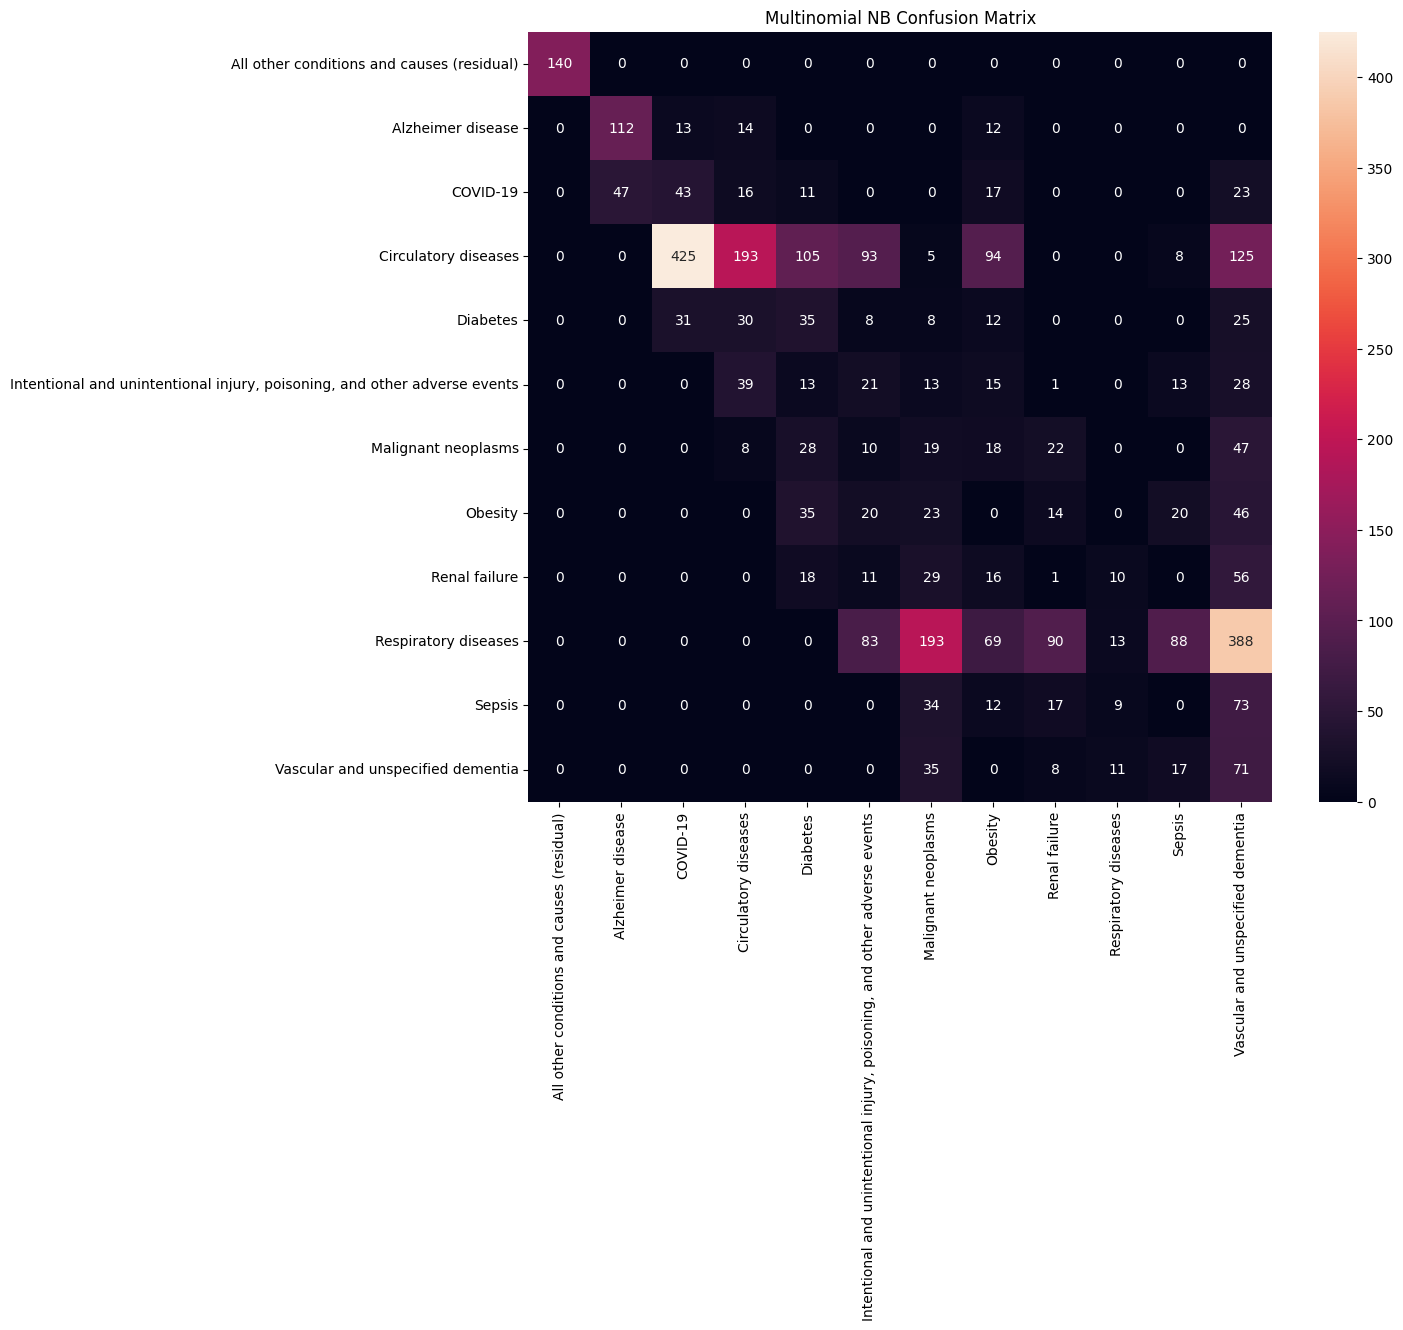

In [ ]:

cm_multi = confusion_matrix(y_test_multi, y_pred_multi)
plt.figure(figsize=(12,10))
sns.heatmap(cm_multi, annot=True, fmt='d', 
            xticklabels=le_condition_group.classes_,
            yticklabels=le_condition_group.classes_)
plt.title('Multinomial NB Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

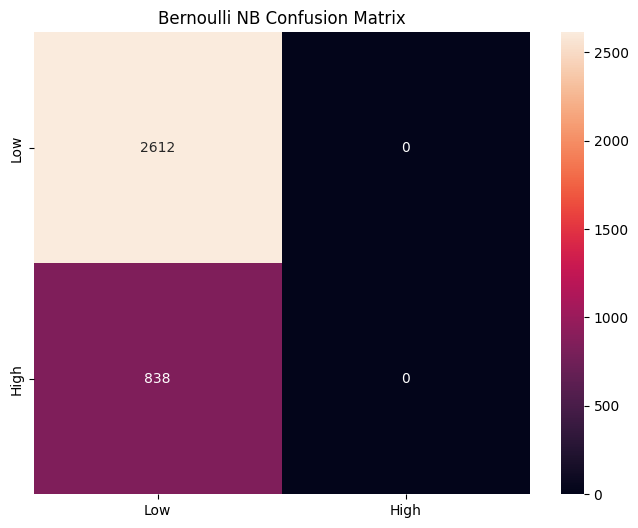

In [14]:
cm_bern = confusion_matrix(y_test_bern, y_pred_bern)
plt.figure(figsize=(8,6))
sns.heatmap(cm_bern, annot=True, fmt='d', 
            xticklabels=['Low','High'],
            yticklabels=['Low','High'])
plt.title('Bernoulli NB Confusion Matrix')
plt.show()